In [347]:
import os
import glob
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   desitarget.io         import read_targets_in_tiles
from   desitarget.geomask    import circles
from   desimodel.focalplane  import get_tile_radius_deg 
from   desitarget.mtl        import make_mtl, mtldatamodel

In [423]:
desilbg_cat = Table()

In [424]:
for ttype in ['bxdrops', 'udrops', 'gdrops']:
    for file in glob.glob('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/{}/*.fits'.format(ttype)):
        desilbg_cat = vstack((desilbg_cat, Table.read(file)))
        
    print('Collected {}'.format(ttype))

Collected bxdrops
Collected udrops
Collected gdrops


In [425]:
n = len(desilbg_cat)

In [426]:
n

87938

In [427]:
desilbg_cat['TARGETID'] = np.arange(n, dtype=np.int)
desilbg_cat['PRIORITY'] = np.array(desilbg_cat['PRIORITY'].data, dtype=np.int32)
 
desilbg_cat['OBSCONDITIONS'] = np.ones(n, dtype='i4') * (obsconditions.DARK + obsconditions.GRAY)

desilbg_cat['DESI_TARGET'] = np.ones(n, dtype='i8') * desi_mask.SCND_ANY
desilbg_cat['BGS_TARGET'] = np.zeros(n, dtype='i8')
desilbg_cat['MWS_TARGET'] = np.zeros(n, dtype='i8')

desilbg_cat['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
desilbg_cat['BRICKID'] = np.full(n, 0)    #- required !?!
desilbg_cat['BRICK_OBJID'] = np.arange(n)

desilbg_cat['NUMOBS_MORE'] = np.ones(n, dtype='i8')

#- dummy values for fluxes
for filt in ['G', 'R', 'Z']:
    desilbg_cat['FIBERFLUX_' + filt] = np.zeros(n, dtype='f4')
    desilbg_cat['FIBERFLUX_IVAR_' + filt] = np.ones(n, dtype='f4')
    
desilbg_cat.meta['EXTNAME'] = 'MTL'

In [428]:
desilbg_cat = desilbg_cat[desilbg_cat['PRIORITY'] >= 0]

In [429]:
for sample in ['CLAUDS-BX', 'CLAUDS-U', 'CLAUDS-G']:
    sample = desilbg_cat[desilbg_cat['SAMPLE'] == sample]
    
    print(np.unique(sample['PRIORITY'], return_counts=True))

(<Column name='PRIORITY' dtype='int32' length=10>
 1000
 2000
 3000
 4000
 5000
 6000
 7000
 8000
 9000
10000, array([471, 500, 500, 500, 500, 500, 500, 500, 500, 500]))
(<Column name='PRIORITY' dtype='int32' length=10>
 1000
 2000
 3000
 4000
 5000
 6000
 7000
 8000
 9000
10000, array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))
(<Column name='PRIORITY' dtype='int32' length=10>
 999
1999
2999
3999
4999
5999
6999
7999
8999
9999, array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,  550]))


In [430]:
desilbg_cat = desilbg_cat['TARGETID', 'RA', 'DEC', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SUBPRIORITY', 'PRIORITY', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID', 'OBSCONDITIONS', 'SAMPLE']

In [431]:
desilbg_cat['PRIORITY_INIT'] = desilbg_cat['PRIORITY']
desilbg_cat['NUMOBS_INIT'] = np.ones(len(desilbg_cat), dtype='i8')

In [432]:
desilbg_cat

TARGETID,RA,DEC,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,PRIORITY,BRICKNAME,BRICKID,BRICK_OBJID,OBSCONDITIONS,SAMPLE,PRIORITY_INIT,NUMOBS_INIT
int64,float64,float64,int64,int64,int64,float64,int32,str8,int64,int64,int32,bytes9,int32,int64
0,149.96138441952732,2.7349397424298587,4611686018427387904,0,0,0.8603402204106536,4000,000p0000,0,0,3,CLAUDS-BX,4000,1
1,149.53542018795022,2.507909101926159,4611686018427387904,0,0,0.4425664378061931,4000,000p0000,0,1,3,CLAUDS-BX,4000,1
2,150.34330004246465,1.4895417291298887,4611686018427387904,0,0,0.9034558141457554,4000,000p0000,0,2,3,CLAUDS-BX,4000,1
3,149.27919766826398,1.0619677642823435,4611686018427387904,0,0,0.10466589520553027,4000,000p0000,0,3,3,CLAUDS-BX,4000,1
4,149.52124949146295,1.3126551848700636,4611686018427387904,0,0,0.9056231113633675,4000,000p0000,0,4,3,CLAUDS-BX,4000,1
5,151.02333918048328,1.3975964906953156,4611686018427387904,0,0,0.9620605257212207,4000,000p0000,0,5,3,CLAUDS-BX,4000,1
6,148.93639414633878,2.7606773165543026,4611686018427387904,0,0,0.9581707426944186,4000,000p0000,0,6,3,CLAUDS-BX,4000,1
7,150.60217360274947,2.562128774847552,4611686018427387904,0,0,0.653024150622941,4000,000p0000,0,7,3,CLAUDS-BX,4000,1
8,149.22249921805732,1.6289185759523928,4611686018427387904,0,0,0.5796682469977098,4000,000p0000,0,8,3,CLAUDS-BX,4000,1


In [26]:
cra = np.mean(desilbg_cat['RA'])
cdec = np.mean(desilbg_cat['DEC'])

In [15]:
trad = get_tile_radius_deg()

In [53]:
tiles = io.load_tiles()

In [54]:
isin, indx = is_point_in_desi(tiles, desilbg_cat['RA'], desilbg_cat['DEC'], radius=None, return_tile_index=True)

In [55]:
np.unique(indx)

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11746, 11747,
       13744, 13745, 14033])

In [56]:
tiles = Table(tiles[indx])

In [57]:
tiles = tiles[0]

In [297]:
tiles

TILEID,RA,DEC,PROGRAM,OBSCONDITIONS,IN_DESI
int32,float64,float64,str6,int32,int16
11155,150.1294839386775,2.185185378998723,DARK,1,1


In [300]:
tiles['RA'] = cra
tiles['DEC'] = cdec
tiles['PASS'] = 1

tiles = tiles['TILEID', 'RA', 'DEC', 'PROGRAM', 'OBSCONDITIONS', 'IN_DESI', 'PASS']

In [301]:
tiles = Table(tiles)
tiles

TILEID,RA,DEC,PROGRAM,OBSCONDITIONS,IN_DESI,PASS
int32,float64,float64,str6,int32,int16,int64
11155,150.1294839386775,2.185185378998723,DARK,1,1,1


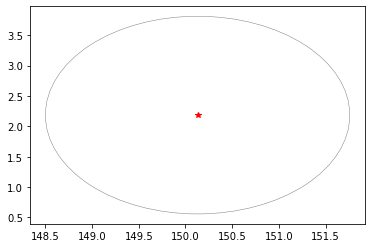

In [302]:
circles(tiles['RA'], tiles['DEC'], trad, c='k', fc='None', alpha=0.5, lw=0.5)

pl.plot(cra, cdec, marker='*', c='r')

In [303]:
tiles.write('/global/cscratch1/sd/mjwilson/DESILBG/final/survey/tiles_deslibg.fits', overwrite=True)

In [452]:
isin, indx = is_point_in_desi(tiles, desilbg_cat['RA'], desilbg_cat['DEC'], radius=None, return_tile_index=True)

In [453]:
100. * np.count_nonzero(isin) / len(desilbg_cat)

94.37528815122177

In [454]:
desilbg_cat = desilbg_cat[isin]

In [ ]:
desilbg_mtl = make_mtl(desilbg_cat, 'GRAY|DARK', trimcols=True)

desilbg_mtl['SCND_TARGET'] = np.ones(len(desilbg_mtl), dtype='i8')
desilbg_mtl['NUMOBS_INIT'] = np.ones(len(desilbg_mtl), dtype='i8')
desilbg_mtl['NUMOBS_MORE'] = np.ones(len(desilbg_mtl), dtype='i8')

for nreal in np.arange(10, 25, 1):
    np.random.seed(nreal)

    desilbg_mtl['SUBPRIORITY'] = np.random.uniform(0., 1., len(desilbg_mtl))
    
    print(nreal, np.sum(desilbg_mtl['SUBPRIORITY']))
    
    desilbg_mtl.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/desilbg_mtl_{:d}.fits'.format(nreal), overwrite=True, format='fits')

In [18]:
skies = read_targets_in_tiles('/project/projectdirs/desi/target/catalogs/dr8/0.39.0/skies/', tiles=tiles)

In [278]:
gfas  = read_targets_in_tiles('/project/projectdirs/desi/target/catalogs/dr8/0.39.0/gfas/', tiles=tiles)

In [279]:
gfas = Table(gfas)

In [280]:
gfas['SUBPRIORITY']   = np.random.uniform(0, 1, len(gfas))
gfas['OBSCONDITIONS'] = np.ones(len(gfas), dtype='i4') * obsconditions.DARK
gfas['DESI_TARGET']   = desi_mask.STD_FAINT

In [281]:
gfas=gfas[gfas['TARGETID'] >= 0]

In [282]:
gfas

RELEASE,TARGETID,BRICKID,BRICK_OBJID,RA,DEC,RA_IVAR,DEC_IVAR,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,REF_EPOCH,PARALLAX,PARALLAX_IVAR,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,URAT_ID,URAT_SEP,HPXPIXEL,SUBPRIORITY,OBSCONDITIONS,DESI_TARGET
int32,int64,int32,int32,float64,float64,float32,float32,str4,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float64,int32,int64
8000,35185820675605962,345370,1482,150.64577188239159,2.4406430199609384,858027650.0,663117760.0,PSF,37.349262,90.36481,106.39152,31.813318,7.880392,5.4741583,244000361,T2,1991.625,0.0,0.0,4.6,-3.1999998,127551.02,118906.06,11.893,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27257,0.8011359943277362,1,8589934592
8000,35185802560405756,341051,252,150.88582682267227,1.642436657780213,733761700.0,1065255800.0,PSF,49.859394,46.101273,81.542915,42.840973,30.044582,12.284751,244007261,T2,1991.74,0.0,0.0,-48.7,20.300001,118906.06,147929.0,11.757,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27256,0.8934941278705506,1,8589934592
8000,35185820688189421,345373,2029,151.30821043202545,2.5034946765182293,7823771600.0,5672170000.0,PSF,12160.119,49652.723,18191.316,0.0071901074,0.003369988,0.0027330364,247000021,T2,1991.6699,0.0,0.0,40.600002,-86.1,694444.4,694444.4,10.526,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27257,0.44967727589764317,1,8589934592
8000,35185820671415169,345369,4993,150.37674342013227,2.604357659982102,4237939700.0,2563691800.0,PSF,20307.102,29004.303,10919.071,0.015598972,0.0077963937,0.006863946,247000601,T2,1991.44,0.0,0.0,-34.600002,6.6,346020.75,308642.0,11.076,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27259,0.8906924356762166,1,8589934592
8000,35185832763589786,348252,1178,151.1573548396282,2.943814629548075,1223979800.0,622403900.0,PSF,-0.43598965,2.9669113,5.1432548,217.4261,50.941643,20.946547,247014551,T2,1991.655,0.0,0.0,-51.7,6.5,137174.2,118906.06,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27257,0.9691234582626669,1,8589934592
8000,35185772353032148,333849,4052,150.47004694028806,0.5941707986969181,47630097000000.0,29127160000000.0,PSF,32.313305,57.11468,70.94632,275.09753,76.75252,43.579887,3833583595323656192,G2,2015.5,0.15102151,8.449016,2.609444,-4.319082,1.7625748,0.9127424,18.299976,335.15485,18.627842,26.442356,17.60298,49.452515,0.0,-99,-99.0,27239,0.4152731239266114,1,8589934592
8000,35185772357227118,333850,4718,150.50299448542532,0.6023058070049063,46301723000000.0,102682610000000.0,PSF,2.2333755,9.731335,75.579384,1158.0974,314.11456,59.291363,3833607028665226240,G2,2015.5,1.7560444,2.0995522,-2.000868,4.8951054,1.6932788,1.9958805,19.506798,178.77809,21.64139,6.273142,18.232414,42.287807,0.0,-99,-99.0,27239,0.7852789654220628,1,8589934592
8000,35185772353032250,333849,4154,150.4864659441625,0.5983619573534122,29966012000000.0,119225360000000.0,PSF,5.478841,21.582912,54.801865,852.09564,158.99939,63.607407,3833607063024962816,G2,2015.5,0.87622523,1.3459541,-81.03003,-55.1723,1.9438444,2.0688212,19.22287,236.80893,20.189518,9.151334,18.230669,41.131794,0.15608715,-99,-99.0,27239,0.528672154234866,1,8589934592
8000,35185772357227454,333850,5054,150.5160759192758,0.6178112453831867,5366330000000000.0,7503186000000000.0,PSF,522.10175,813.00244,914.08923,29.649288,13.551857,5.441247,3833607170399090688,G2,2015.5,0.697692,314.06693,-0.37623322,1.6068532,159.83246,192.578,15.328591,2010.7217,15.691347,280.39514,14.812709,378.80737,0.062157266,-99,-99.0,27239,0.2019416715881014,1,8589934592


In [283]:
np.count_nonzero(np.isin(skies['TARGETID'], desilbg_cat['TARGETID']))

0

In [284]:
np.count_nonzero(np.isin(gfas['TARGETID'], desilbg_cat['TARGETID']))

0

In [36]:
fitsio.write('/global/cscratch1/sd/mjwilson/DESILBG/final/skies/skies_desilbg.fits', skies)

In [87]:
gfas.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/gfas/gfas_desilbg.fits', format='fits', overwrite=True)

In [327]:
rundatestr = "2019-01-01T00:00:00"
rundate    = datetime.strptime(rundatestr, "%Y-%m-%dT%H:%M:%S")

rundate

datetime.datetime(2019, 1, 1, 0, 0)

In [448]:
for nreal in np.arange(10, 25, 1):
    print('Assigning realization {:d}'.format(nreal))
    
    cmd  = 'fiberassign --overwrite --mtl /global/cscratch1/sd/mjwilson/DESILBG/final/targets/desilbg_mtl_{:d}.fits'.format(nreal) 
    cmd += ' --gfafile /global/cscratch1/sd/mjwilson/DESILBG/final/targets/gfas/gfas_desilbg.fits' 
    cmd += ' --sky /global/cscratch1/sd/mjwilson/DESILBG/final/targets/skies/skies_desilbg.fits'
    cmd += ' --rundate {}'.format(rundatestr)
    cmd += ' --footprint /global/cscratch1/sd/mjwilson/DESILBG/final/survey/tiles_deslibg.fits'
    cmd += ' --outdir /global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/{:d}/'.format(nreal)
    
    os.system(cmd)

Assigning realization 10
Assigning realization 11
Assigning realization 12
Assigning realization 13
Assigning realization 14
Assigning realization 15
Assigning realization 16
Assigning realization 17
Assigning realization 18
Assigning realization 19
Assigning realization 20
Assigning realization 21
Assigning realization 22
Assigning realization 23
Assigning realization 24


In [461]:
fa = fits.open('/global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/0/fiberassign-011155.fits')

In [462]:
fa.info()

Filename: /global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/0/fiberassign-011155.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1  FIBERASSIGN    1 BinTableHDU    133   5000R x 48C   [K, I, J, J, J, J, D, D, E, E, E, E, E, E, K, B, 3A, E, E, I, J, D, J, K, K, K, J, K, K, K, K, D, K, 15A, 19A, 14A, J, J, 8A, J, E, E, E, E, E, E, E, K]   
  2  SKY_MONITOR    1 BinTableHDU     85   20R x 24C   [J, J, I, K, J, J, K, B, D, D, E, E, 8A, J, I, J, J, D, E, E, E, E, E, E]   
  3  GFA_TARGETS    1 BinTableHDU    119   918R x 41C   [J, K, J, J, D, D, E, E, 4A, E, E, E, E, E, E, K, 2A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, D, J, K, I, I, I, I]   
  4  TARGETS       1 BinTableHDU    133   5020R x 48C   [K, I, J, J, J, J, D, D, E, E, E, E, E, E, K, B, 3A, E, E, I, J, D, J, K, K, K, J, K, K, K, K, D, K, 15A, 19A, 14A, J, J, 8A, J, E, E, E, E, E, E, E, K]   
  5  POTENTIAL_ASSIGNMENTS    1 BinTableHDU     43   

In [463]:
fa_fiberassign = Table(fa[1].data)
fa_targets = Table(fa[4].data)
fa_potential = Table(fa[5].data)

In [464]:
fa_fiberassign 

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,DESI_TARGET,BGS_TARGET,MWS_TARGET,PRIORITY_INIT,NUMOBS_INIT,SCND_TARGET,NUMOBS_MORE,NUMOBS,Z,ZWARN,TARGET_STATE,TIMESTAMP,VERSION,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,BLOBDIST,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int16,int32,float64,int32,int64,int64,int64,int32,int64,int64,int64,int64,float64,int64,str15,str19,str14,int32,int32,str8,int32,float32,float32,float32,float32,float32,float32,float32,int64
7092,0,95,95,0,0,150.1308895694192,1.4677665655992147,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,-0.15403363,-175.78929,0,0,0.8258369147709095,63,4611686018427387904,0,0,6000,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
62802,0,62,62,1,0,150.33733392810026,1.5373939208449647,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,-50.696693,-158.64343,0,0,0.022456052863515263,63,4611686018427387904,0,0,6999,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6341,0,102,102,2,0,150.32300797872864,1.3924672175631012,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,-47.31516,-194.77702,0,0,0.9638047592086784,63,4611686018427387904,0,0,7000,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13289,0,82,82,3,0,150.26461768503071,1.4810338187555332,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,-32.91445,-172.57077,0,0,0.9749525911056648,63,4611686018427387904,0,0,10000,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
52521,0,131,131,4,0,150.08188302069118,1.3651994545709598,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,11.909853,-201.44327,0,0,0.6301541414623324,63,4611686018427387904,0,0,3999,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
60419,0,108,108,5,0,150.06755753022333,1.439325014846789,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,15.378889,-182.87933,0,0,0.9776965272326352,63,4611686018427387904,0,0,5999,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
21659,0,119,119,6,0,150.0780721991743,1.416234765470105,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,12.814753,-188.65024,0,0,0.8743543828151266,63,4611686018427387904,0,0,8000,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32010,0,64,64,7,0,150.23528164754768,1.5615338567991155,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,-25.70014,-152.55003,0,0,0.9348936100004379,63,4611686018427387904,0,0,10000,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
52726,0,72,72,8,0,150.2978580366984,1.5284125842398204,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,-41.031216,-160.82454,0,0,0.7410120181788789,63,4611686018427387904,0,0,3999,1,1,1,0,-1.0,-1,,2020-11-26T04:39:13,0.45.1.dev4292,0,0,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [401]:
np.count_nonzero(np.isin(fa_fiberassign['TARGETID'], skies['TARGETID']))

1128

In [402]:
np.count_nonzero(np.isin(fa_fiberassign['TARGETID'], gfas['TARGETID']))

0

In [403]:
assigned = desilbg_cat[np.isin(desilbg_cat['TARGETID'], fa_fiberassign['TARGETID'])]

In [404]:
np.count_nonzero(np.isin(fa_potential['TARGETID'], desilbg_cat['TARGETID']))

3872

In [475]:
ufiber, cnts = np.unique(fa_potential[np.isin(fa_potential['TARGETID'], desilbg_cat['TARGETID'])]['FIBER'], return_counts=True)

Text(0.5, 0, 'Fiber conflicts')

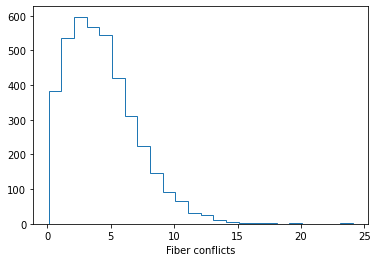

In [487]:
bins = 0.1 + np.arange(25)

pl.hist(cnts, bins=bins, histtype='step')

pl.xlabel('Fiber conflicts')

In [490]:
assigned_sky = fa_fiberassign[fa_fiberassign['OBJTYPE'] == 'SKY']
science = fa_fiberassign[fa_fiberassign['OBJTYPE'] == 'TGT']

Text(0, 0.5, 'DEC')

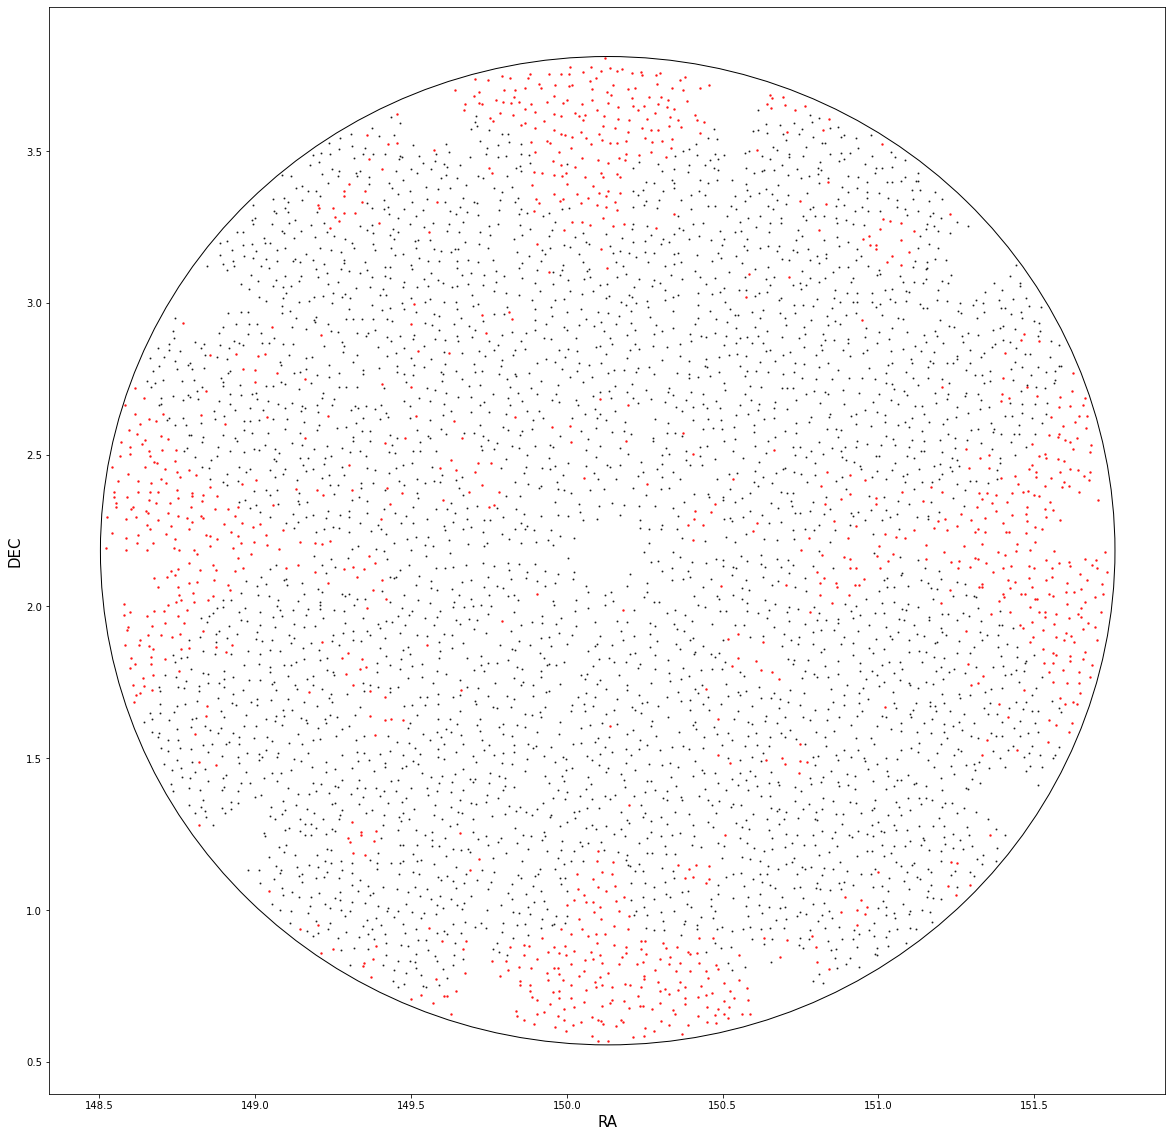

In [494]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))

plt.sca(ax)

circles(tiles['RA'], tiles['DEC'], trad, c='k', fc='w')

ax.plot(assigned_sky['TARGET_RA'], assigned_sky['TARGET_DEC'], marker='.', lw=0.0, markersize=3, c='r', alpha=0.75)
ax.plot(assigned['RA'], assigned['DEC'], marker='.', lw=0.0, markersize=2, c='k', alpha=0.75)

ax.set_xlabel('RA', fontsize=15)
ax.set_ylabel('DEC', fontsize=15)

In [471]:
def completeness(real, sample):
    fa = fits.open('/global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/{:d}/fiberassign-011155.fits'.format(real))
    fa_fiberassign = Table(fa[1].data)

    assigned = desilbg_cat[np.isin(desilbg_cat['TARGETID'], fa_fiberassign['TARGETID'])]
    assignable = desilbg_cat [np.isin(desilbg_cat['TARGETID'], fa_potential['TARGETID'])]
    
    ups = np.unique(desilbg_cat[desilbg_cat['SAMPLE'] == sample]['PRIORITY'])
    
    result = np.array([100. * len(assigned[(assigned['PRIORITY'] == up) & (assigned['SAMPLE'] == sample)]) / len(assignable[(assignable['PRIORITY'] == up) & (assignable['SAMPLE'] == sample)]) for up in ups])
    
    return ups, result

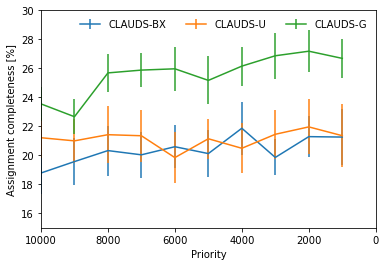

In [492]:
for sample in ['CLAUDS-BX', 'CLAUDS-U', 'CLAUDS-G']:
    results = []
    
    for real in np.arange(25):
        ups, result = completeness(real, sample=sample)

        results.append(result.tolist())
    
    results = np.array(results)

    pl.errorbar(ups, results.mean(axis=0), results.std(axis=0), label=sample)

pl.xlim(10000, 0)
pl.ylim(15., 30)

pl.xlabel('Priority')
pl.ylabel('Assignment completeness [%]')

pl.legend(frameon=False, ncol=3)

### Done.